<a id='table_of_contents'></a>

0. [Import libraries](#import_libraries)
1. [Import and tweak data](#import_data)
2. [Data exploration](#data_exploration)

# 0. Import libraries <a id='import_libraries'></a>
[Back to top](#table_of_contents)

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# set dpi
sns.set_theme(rc={"figure.dpi": 96, "savefig.dpi": 300})

# 1. Import and tweak data<a id='import_data'></a>
[Back to top](#table_of_contents)

In [14]:
data_dir: Path = Path("../../data")
file: Path = data_dir / "processed" / "05052024_roast_review_cleaned.csv"
df: pd.DataFrame = pd.read_csv(file)

In [15]:
def tweak_df(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_drop = [
        "territorial_entity_1_identifiers",
        "territorial_entity_2_identifiers",
        "roaster_location_identifier",
        "territorial_entity_1",
        "territorial_entity_2",
        "est_price",
        "consumer_price_index",
        "quantity_value",
        "quantity_unit",
    ]
    return (
        df.drop(columns=cols_to_drop)
        .astype(
            {
                "coffee_origin_country": "category",
                "roast_level": "category",
                "roaster_us_state": "category",
                "roaster_country": "category",
                "review_date": "datetime64[ns]",
                "rating": "float64",
            }
        )
        .astype(
            {col: "int" for col in ["aroma", "aftertaste", "acidity", "body", "flavor"]}
        )
        .assign(year=lambda x: x["review_date"].dt.year)
        .rename(columns={"price_usd_adj_2024_per_lb": "price_usd_adj_lb"})
        # Gesha and Geisha refer to the same coffee varietal
        .replace(r"Gesha", "Geisha", regex=True)
        # Rename for better readability when plotting
        .replace("Democratic Republic of the Congo", "Congo (DRC)")
        .replace("People's Republic of China", "China")
        .replace("United Arab Emirates", "UAE")
    )


coffee = tweak_df(df)
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232 entries, 0 to 4231
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   rating                 4232 non-null   float64       
 1   roaster                4232 non-null   object        
 2   title                  4232 non-null   object        
 3   blind_assessment       4232 non-null   object        
 4   bottom_line            2760 non-null   object        
 5   roaster_location       4232 non-null   object        
 6   coordinate location    4232 non-null   object        
 7   og_roaster_location    4232 non-null   object        
 8   roaster_country        4232 non-null   category      
 9   coffee_origin          4232 non-null   object        
 10  coffee_origin_country  4232 non-null   category      
 11  roast_level            4232 non-null   category      
 12  review_date            4232 non-null   datetime64[ns]
 13  aro

In [16]:
coffee.describe()

,rating,review_date,aroma,body,flavor,aftertaste,acidity,agtron_external,agtron_ground,price_value,price_value_usd_hist,price_usd_adj_2024,quantity_in_lbs,price_usd_adj_lb,year
count,4232.000000,4232,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000
mean,92.724008,2018-02-15 12:47:38.223062272,8.761815,8.505671,8.922968,8.108223,8.418242,56.076796,74.330577,316.062042,21.902857,26.267590,0.673020,50.704308,2017.630435
min,75.000000,2010-03-01 00:00:00,5.000000,6.000000,3.000000,4.000000,5.000000,0.000000,30.000000,3.300000,3.300000,3.880000,0.040000,5.360000,2010.000000
25%,92.000000,2014-08-01 00:00:00,9.000000,8.000000,9.000000,8.000000,8.000000,53.000000,71.000000,15.990000,14.950000,18.437500,0.500000,25.600000,2014.000000
50%,93.000000,2018-10-01 00:00:00,9.000000,9.000000,9.000000,8.000000,8.000000,57.000000,76.000000,19.500000,18.000000,21.785000,0.750000,30.425000,2018.000000
75%,94.000000,2021-11-01 00:00:00,9.000000,9.000000,9.000000,8.000000,9.000000,60.000000,80.000000,34.950000,22.950000,26.272500,0.750000,41.345000,2021.000000
max,98.000000,2024-01-01 00:00:00,10.000000,10.000000,10.000000,10.000000,10.000000,86.000000,99.000000,120000.000000,387.480000,388.420000,6.000000,5180.000000,2024.000000
std,1.888504,NaN,0.510330,0.536950,0.457322,0.558646,0.600502,6.355795,8.445195,3869.941660,16.731940,19.524478,0.227317,123.361985,4.105038


# 2. Overview <a id='data_exploration'></a>
[Back to top](#table_of_contents)


This data set contains 4232 roast reviews from March 2010 to January 2024.

Ratings vary from 75 to 98 with a median score of 93. Coffeereviews.com chooses to focus on reviewing quality specialty coffees, as such ratings are generally high. Therefore this dataset cannot be taken to be a representative sample of coffees on the market. But it will be useful to understand the variation and characteristics of these selected coffees as representing the higher quality end of the market.


### Rating
Coffee total ratings are on a 100 point scale. Ratings are meant to be interpreted [as follows](https://www.coffeereview.com/how-coffee-review-works/):

> 97+ = Means: “We have not tasted a coffee of this style as splendid as this one for a long, long time”
>
> 95-96 = Perfect in structure, flawless, and shockingly distinctive and beautiful
>
> 93-94 = Exceptional originality, beauty, individuality and distinction, with no significant negative issues whatsoever
>
> 91-92 = An very good to outstanding coffee with excitement and distinction in aroma and flavor – or an exceptional coffee that still perhaps has some issue that some consumers may object to but others will love – a big, slightly imbalanced acidity, for example, or an overly lush fruit
> 
> 89-90 = A very good coffee, drinkable, with considerable distinction and interest.
> 
> 87-88 = An interesting coffee but either distinctive yet mildly flawed, or solid but not exciting.
> 
> 85/86 = An acceptable, solid coffee, but nothing exceptional — the best high-end supermarket whole bean.

### Aroma


### Fields
- `rating`: Overall rating of roast on a scale of 0-100
- `roaster`: Name of roaster
- `title`:  Name of the roast
- `blind_assessment`: Description of the roast from a blind tasting
- `bottom_line`: Summary of the roast
- `roaster_location`: Location of the roaster
- `coordinate location`: Coordinates of the roaster location
- `og_roaster_location`: Location of roaster as seen on the website
- `roaster_country`: Country of the roaster
- `coffee_origin`: Origin of the coffee including region
- `coffee_origin_country`: Country of origin of the coffee
- `roast_level`: Light, Medium-Light, Medium, Medium-Dark, Dark, Very Dark
- `review_date`: Date of the review
- `aroma`: Rating of aroma on a scale of 0-10
- `body`: Rating of body on a scale of 0-10
- `flavor`: Rating of flavor on a scale of 0-10
- `aftertaste`: Rating of aftertaste on a scale of 0-10
- `url`: URL of the review
- `acidity`: Rating of acidity on a scale of 0-10
- `notes`: Prominent flavors and aromas
- `agtron_external`: Agtron rating of the roast
- `agtron_ground`: Agtron rating of the ground roast
- `price_value`: Price of the roast
- `price_currency`: Currency of the `price_value`
- `price_value_usd_hist`: Price value in USD at the time of the review
- `price_usd_adj_2024`: Price value in USD adjusted for inflation to 2024
- `quantity_in_lbs`: Quantity of the roast in pounds
- `price_usd_adj_lb`: Price per pound in USD adjusted for inflation to 2024
- `roaster_county`: County of the roaster
- `roaster_us_state`: State of the roaster if in the US
- `year`: Year of the review

### Avg rating over time

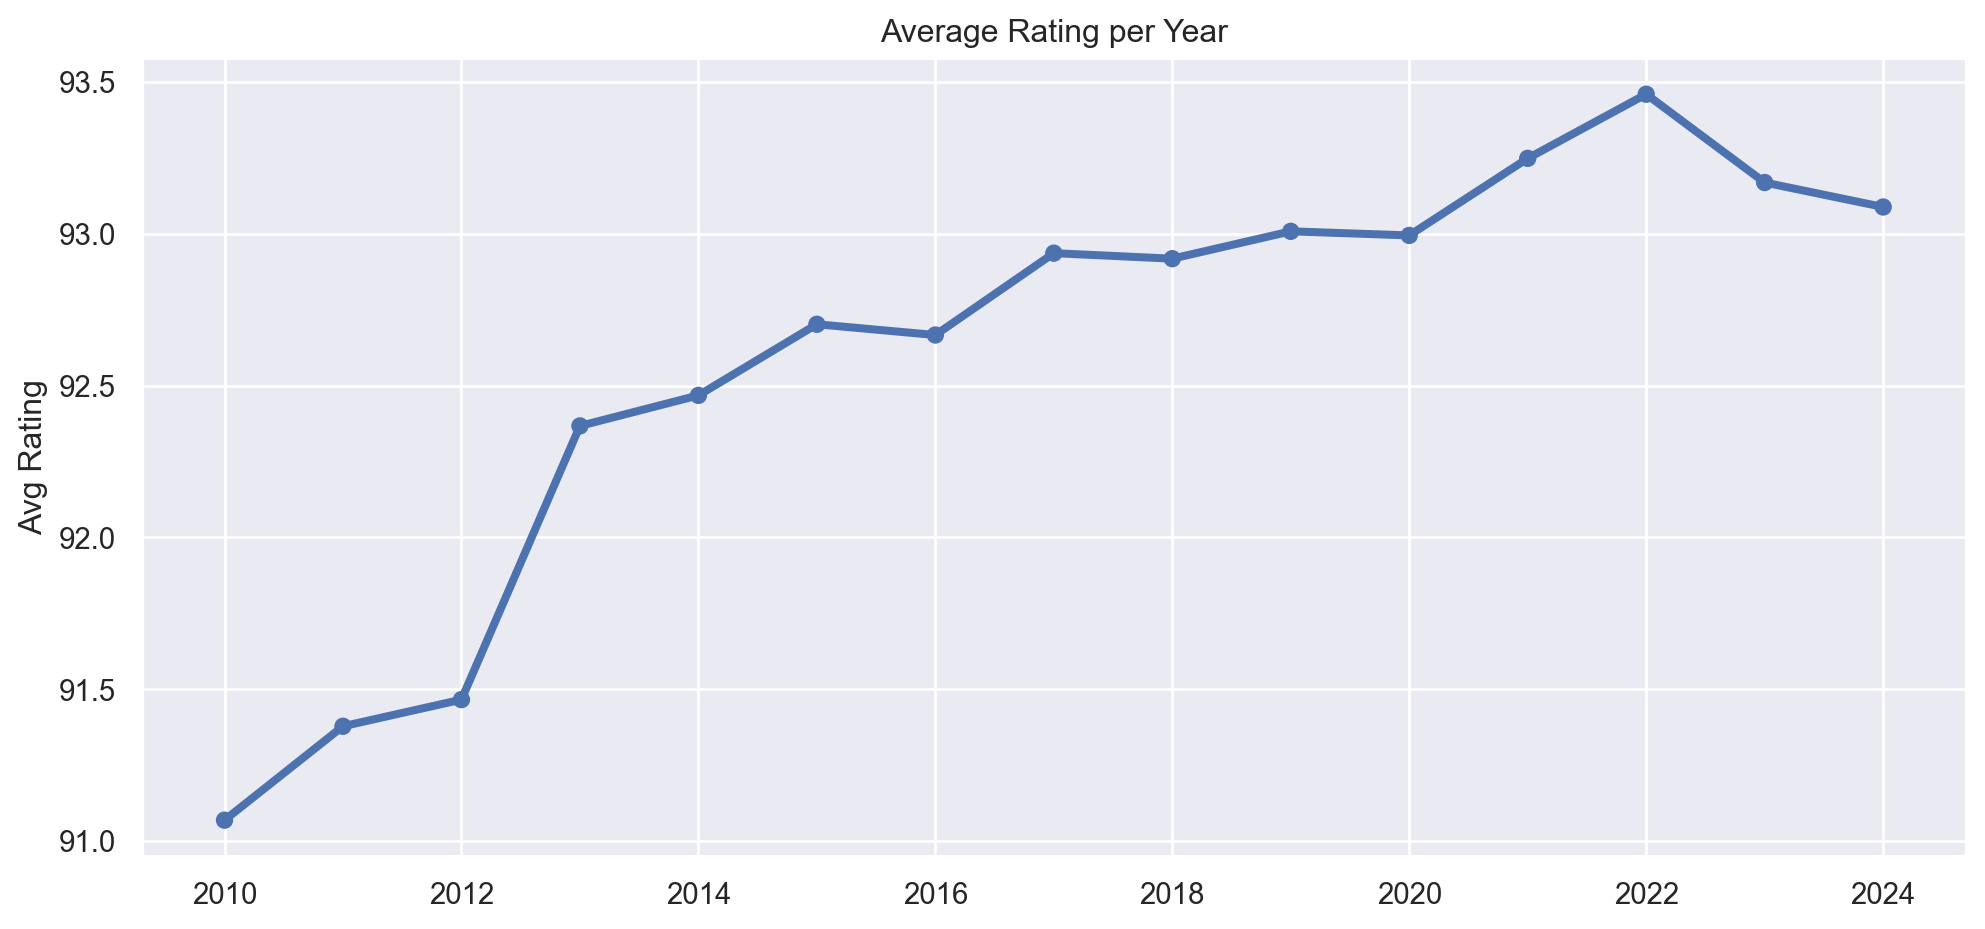

In [17]:
# Average rating per year
(
    coffee.pipe(so.Plot, x="year", y="rating")
    .layout(size=(10.5, 5))
    .add(so.Line(linewidth=3), so.Agg("mean"))
    .add(so.Dot(), so.Agg("mean"))
    .label(x="", y="Avg Rating", title="Average Rating per Year")
)

Because of the selective review process the quality has always been on the high end of the possible range. We can see there is a clear uptick in the average coffee roast rating every year, increasing from just over 91 to just over 93 points from 2010 to 2024. Coffeereview acknowledges this, and beleives it is a result of industry competition creating rising bar of quality: 

>"Also, we have found that the high end of the global coffee community has been relentlessly raising the bar for quality and distinction over the past ten years. We receive considerably more consistently fine samples now than we did even five years ago. So if the ratings at Coffee Review appear to be creeping higher, the reason may not be ratings inflation, but rather a reflection of intensified competition and achievement at the top end of the industry."

### Avg price/lb over time

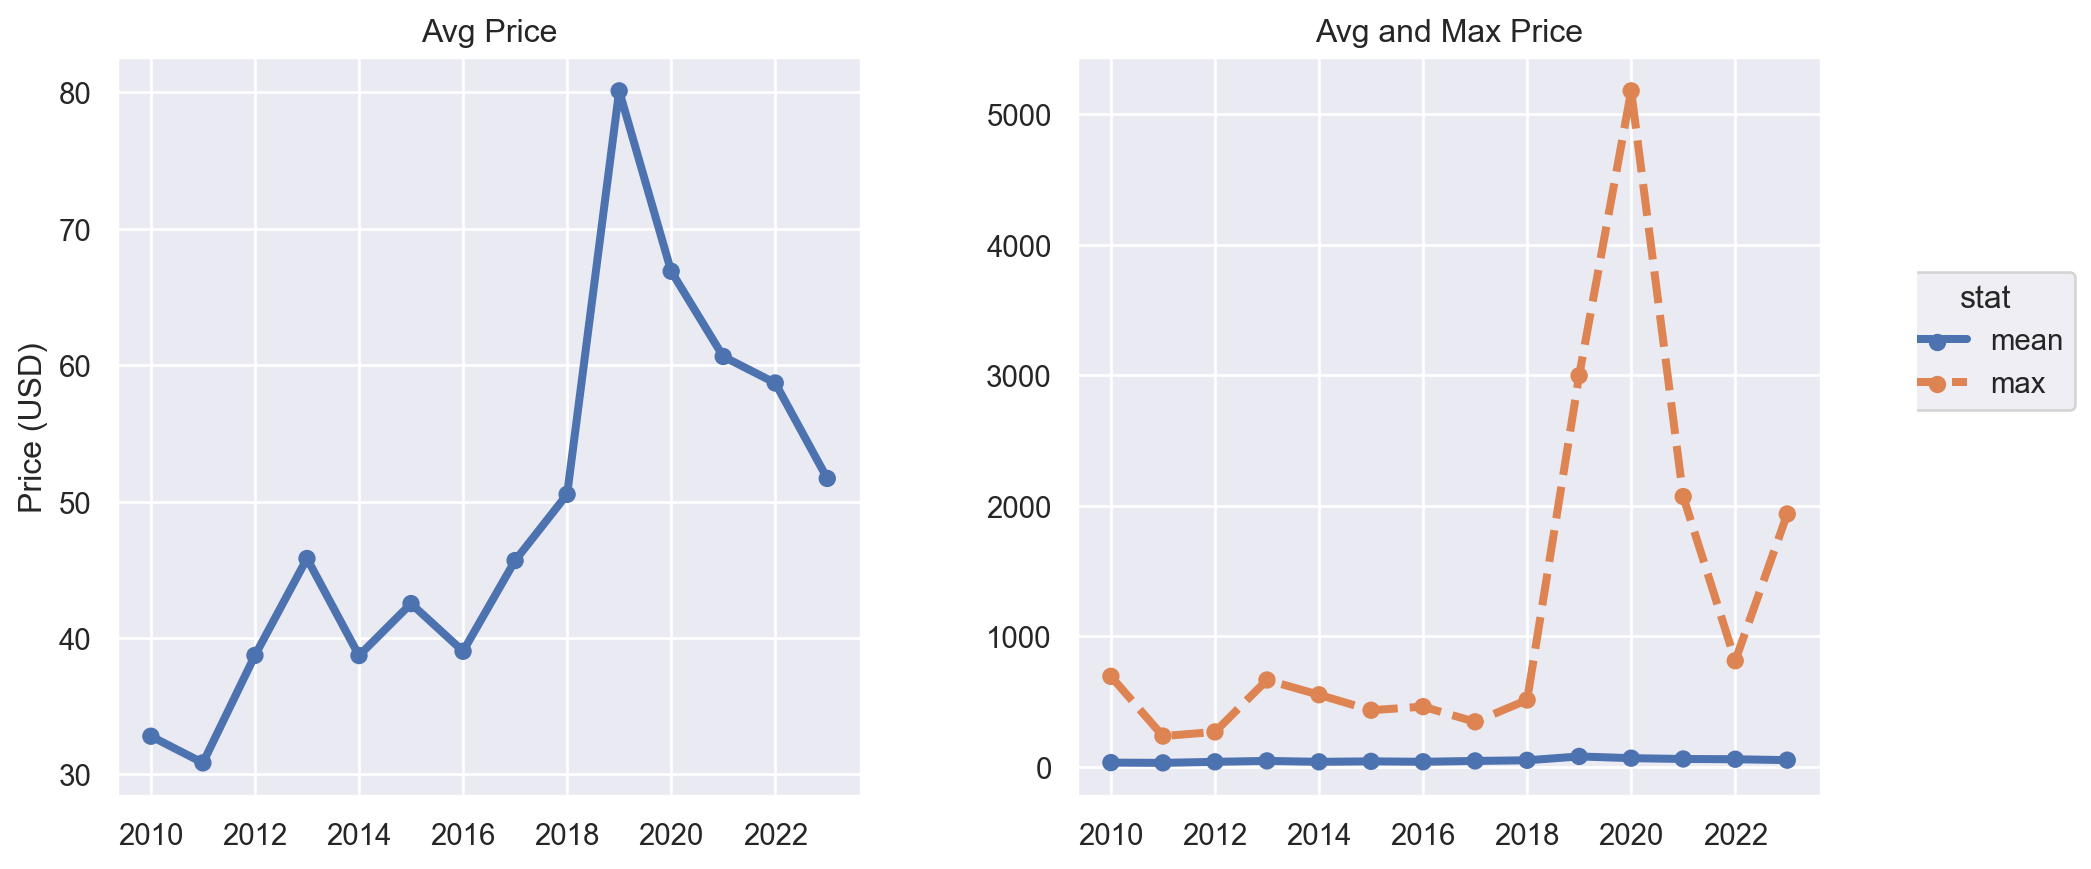

In [18]:
f = mpl.figure.Figure(figsize=(10, 5))
sf1, sf2 = f.subfigures(1, 2)


# Average real price per year
(
    coffee.loc[coffee["year"] < 2024]
    .pipe(so.Plot, x="year", y="price_usd_adj_lb")
    .layout(size=(10.5, 7))
    .add(so.Line(linewidth=3), so.Agg("mean"))
    .add(so.Dot(), so.Agg("mean"))
    .label(x="", y="Price (USD)", title="Avg Price")
    .on(sf1)
    .plot()
)

# Average real price and max real price per year
(
    coffee.groupby("year")
    .agg({"price_usd_adj_lb": ["mean", "max"]})
    .melt(value_name="price", ignore_index=False)
    .rename(columns={"variable_1": "stat"})
    .reset_index()
    .loc[lambda x: x["year"] < 2024, :]
    .pipe(so.Plot, x="year", y="price", color="stat", linestyle="stat")
    .add(so.Line(linewidth=3))
    .label(x="", y="", title="Avg and Max Price")
    .add(so.Dot())
    .on(sf2)
    .plot()
)

The average price in USD of reviewed coffees has also increased over time, after adjusting for inflation. This could be mirroring the increase in average rating over time, or due to any number of other production and economic factors. There is a large spike in the average price in 2019 and 2020 that appears to be cause by a few large outliers of specialty coffees commanding enormous $/lb prices. We will dive into this later.

### Top coffee origin and roaster countries

No. origin countries:  41
No. roaster countries:  22


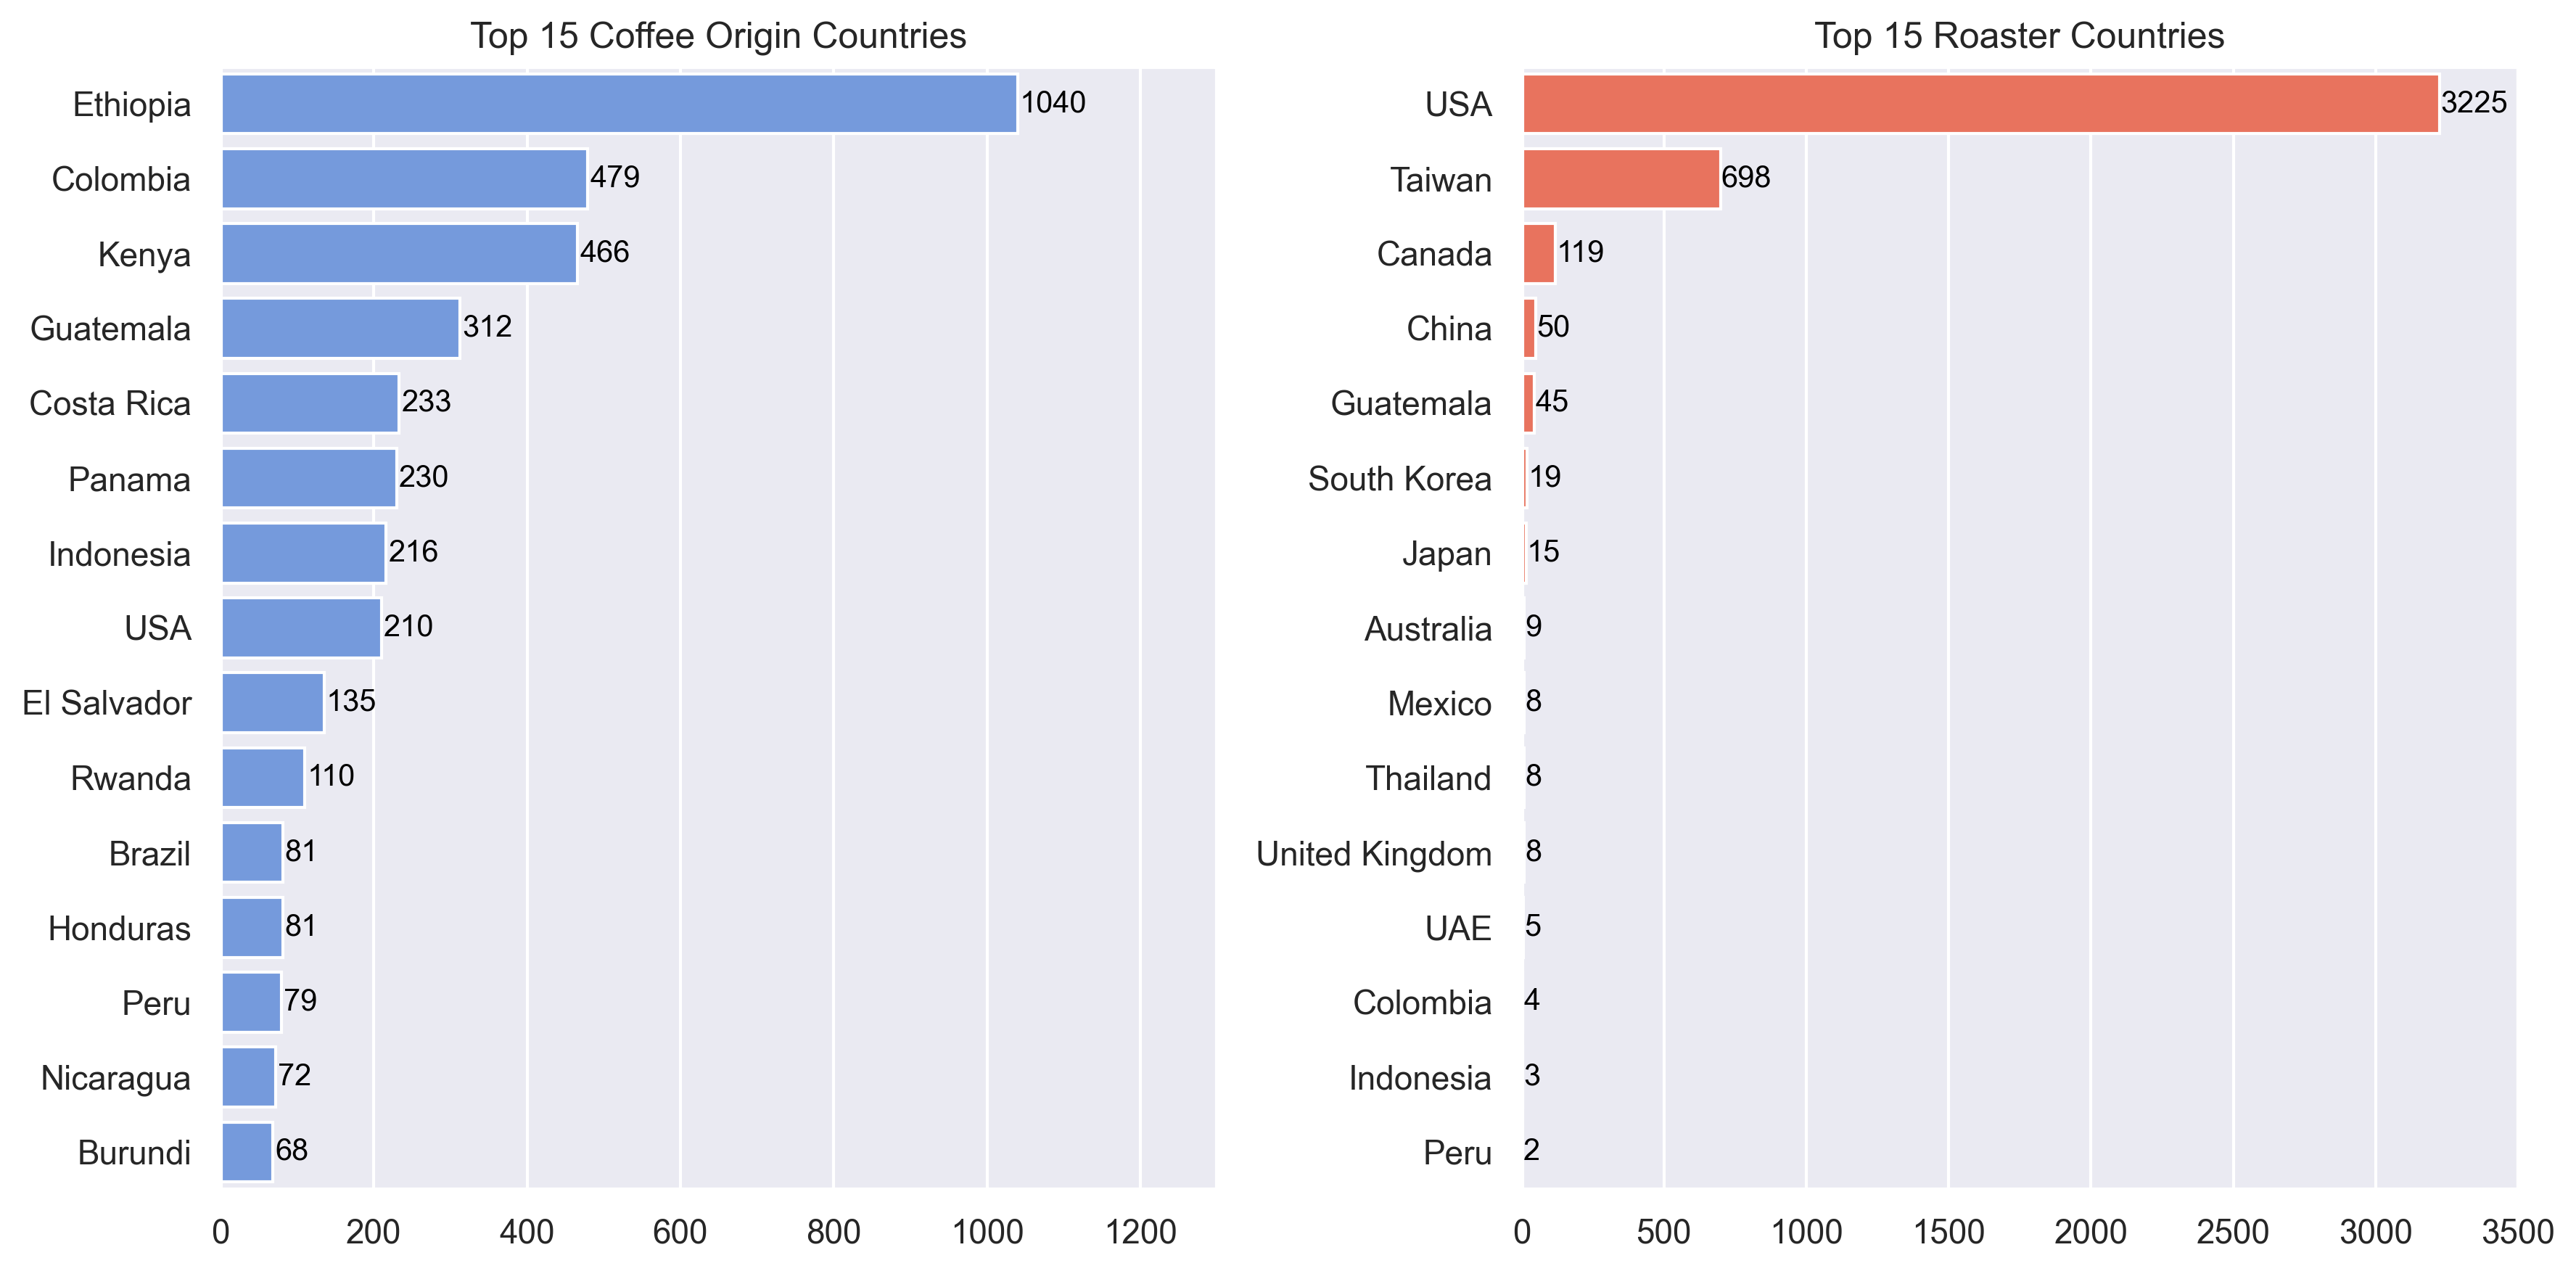

In [36]:
print("No. origin countries: ", coffee["coffee_origin_country"].nunique())
print("No. roaster countries: ", coffee["roaster_country"].nunique())


origin_coun = coffee["coffee_origin_country"].value_counts().head(15).reset_index()
roaster_count = coffee["roaster_country"].value_counts().head(15).reset_index()


def annotate(iter, ax, fontsize: int) -> None:
    for i, v in enumerate(iter):
        ax.text(v + 3, i, str(v), color="black", va="center", fontsize=fontsize)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
sns.barplot(
    origin_count,
    y="coffee_origin_country",
    x="count",
    order=origin_count["coffee_origin_country"],
    ax=ax1,
    color="#6495ed",
)

sns.barplot(
    roaster_count,
    y="roaster_country",
    x="count",
    ax=ax2,
    order=roaster_count["roaster_country"],
    color="tomato",
)

# annotate bars
annotate(origin_count["count"], ax1, 10)
annotate(roaster_count["count"], ax2, 10)

# change the y axis label font size
ax1.set_title("Top 15 Coffee Origin Countries")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xlim(0, 1300)

ax2.set_title("Top 15 Roaster Countries")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_xlim(0, 3500)
plt.tight_layout()
plt.show()

Ethiopia is the most numerous country of origin in the dataset by far at 1040 roast reviews. Colombia and Kenya are nearly tied for second, and Guatemala is in third. *Coffea arabica* originates from Ethiopia

https://www.coffeereview.com/coffee-origins/ethiopia/

The forests of southwestern Ethiopia are the original botanical home of Coffea arabica, and they continue to harbor most of the unexplored genetic diversity still existing in the species.
Much Ethiopia coffee is produced from indigenous Ethiopian varieties of Arabica; these native landrace varieties display symphonic complexities in aroma and flavor that, at their most distinctive, can make even other distinctive varieties of the world. The only currently cultivated competitor to the finest native Ethiopian varieties in respect to cup and complexity is Geisha or Gesha, which is an Ethiopia variety (a particularly brilliant one) brought to the New World.

Almost all Ethiopia coffee is grown by small-holding farmers, most of whom very likely have never used chemical inputs. Not only is this reassuring to consumers, but it also makes a transition to formal organic certification relatively easy, accounting for the widespread availability of superb organic-certified Ethiopias.

Ethiopians deeply care about coffee and understand it. Its lore is woven into their culture. They do not produce great coffee and then go home to drink tea, as Kenyans do, or instant coffee, as sadly occurs in many of the coffee world’s other coffee-growing regions.

Unfortunately for the many cash-poor villages of small-holding Ethiopia farmers, but fortunately for coffee lovers elsewhere in the world, most fine Ethiopia coffees are amazing bargains.

A really distinguished coffee from the Yirgacheffe region is luminous, extraordinary, as great and distinctive as any in the world, yet it is likely to sell for routine, everyday specialty coffee prices.

*World Atlas of Coffee*



---

Given Coffee Reviews is a US-based organization it's not surprising that the coffee roasters reviewed are overwhelmingly base in the USA. What is surprising is how many Taiwanese roasters are represented in this dataset. 

Price
It appears that there are some coffees with very high prices. One review in 2020 has a coffee at >$5000/lb*. We will examine the distribution of prices/lb to see if there are any data errors or outliers to concern ourselves with.

In [20]:
coffee["price_usd_adj_lb"].describe()

count    4232.000000
mean       50.704308
std       123.361985
min         5.360000
25%        25.600000
50%        30.425000
75%        41.345000
max      5180.000000
Name: price_usd_adj_lb, dtype: float64

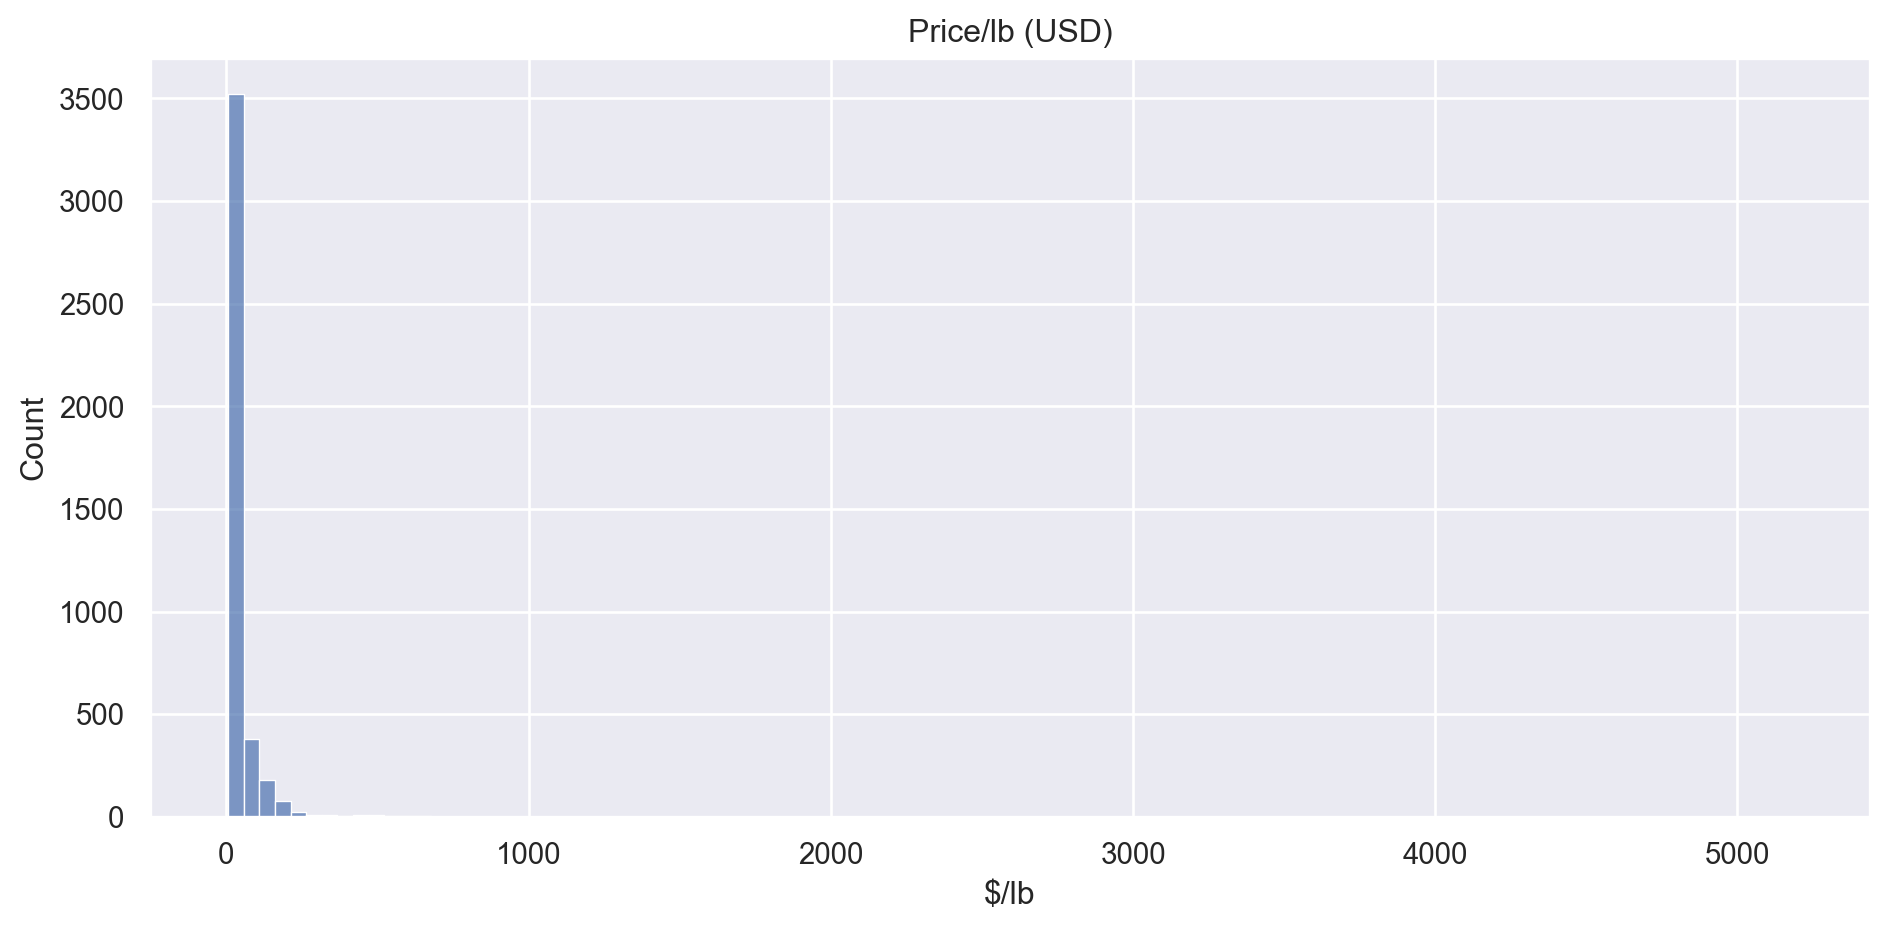

In [21]:
(
    coffee.pipe(so.Plot, x="price_usd_adj_lb")
    .add(so.Bars(), so.Hist(bins=100))
    .label(x="$/lb", y="Count", title="Price/lb (USD)")
    .layout(size=(10, 5))
)

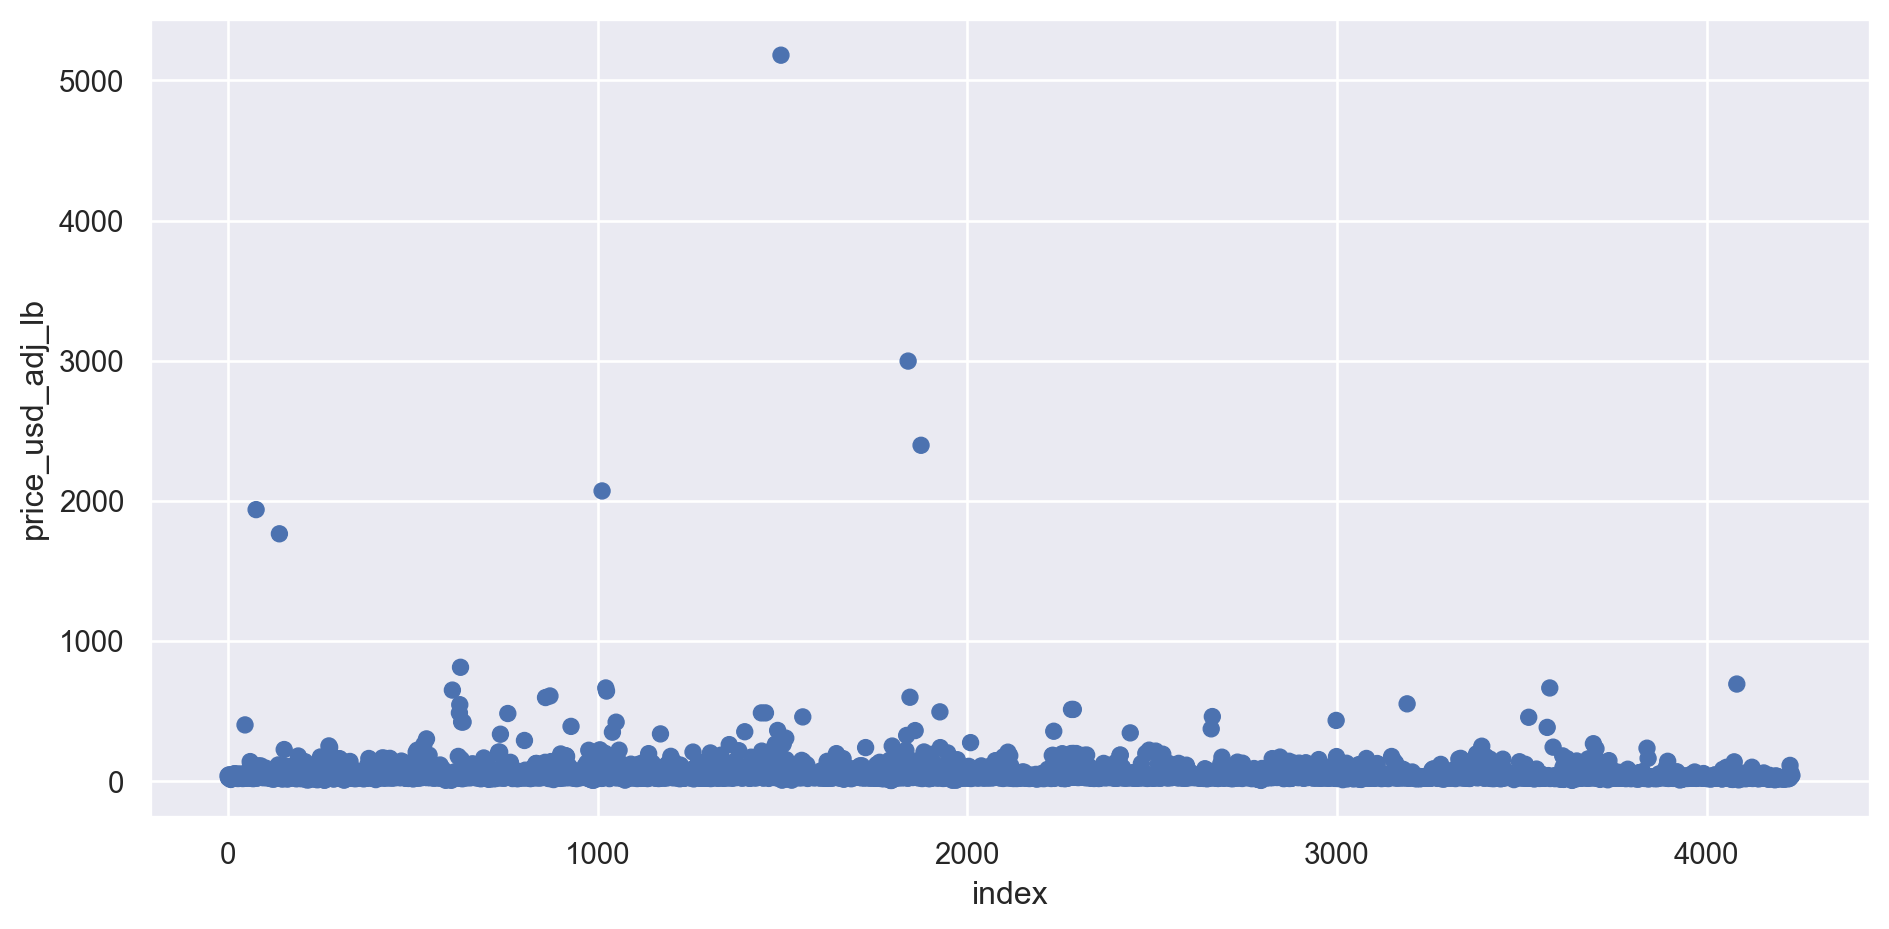

In [22]:
(
    coffee.reset_index()
    .pipe(so.Plot, x="index", y="price_usd_adj_lb")
    .add(so.Dot())
    .layout(size=(10, 5))
)

In [23]:
# $1000/lb looks like a natural cutoff to examine the outliers
coffee[coffee["price_usd_adj_lb"] > 1000].sort_values(
    "price_usd_adj_lb", ascending=False
)

,rating,roaster,title,blind_assessment,bottom_line,roaster_location,coordinate location,og_roaster_location,roaster_country,coffee_origin,...,agtron_ground,price_value,price_currency,price_value_usd_hist,price_usd_adj_2024,quantity_in_lbs,price_usd_adj_lb,roaster_county,roaster_us_state,year
1496,98.0,GK Coffee,GW01 Finca Sophia Olympus Geisha,"Graceful, polished, exquisitely floral. Lavend...",This Best of Panama winner also won us over wi...,Yilan County,"24.75,121.75","Yilan, Taiwan",Taiwan,"Volcan-Candela growing region, Panama",...,76.0,5000.0,TWD,174.83,207.20,0.04,5180.00,NaN,NaN,2020
1840,97.0,Klatch Coffee,Panama Elida Geisha Natural 1029,"Delicately and complexly aromatic, levitatingl...","An ethereal Panama Geisha cup, intricately bal...",Los Angeles,"34.05223,-118.24368","Los Angeles, California",USA,"Boquete growing region, Panama",...,74.0,100.0,USD,100.00,119.91,0.04,2997.75,Los Angeles County,California,2019
1875,98.0,Dragonfly Coffee Roasters,Elida Estate Geisha Green-Tip Natural,Vast yet intimate in its layered intricacy: co...,A flawlessly structured coffee alive with laye...,Boulder,"40.019444444444,-105.29277777778","Boulder, Colorado",USA,"Boquete growing region, Panama",...,78.0,100.0,USD,100.00,119.85,0.05,2397.00,Boulder County,Colorado,2019
1012,95.0,Plat Coffee Roastery,Ninety Plus Panama Geisha Estate MS Joseph Bro...,"Elegantly fruit-toned, juicy-sweet. Passion fr...",A distinctively composed Panama Geisha cup tha...,Hong Kong,"22.278333333333,114.15861111111","Hong Kong, China",China,"Boquete growing region, Panama",...,82.0,280.0,USD,280.00,310.69,0.15,2071.27,NaN,NaN,2021
76,98.0,GK Coffee,GW03 Princesa Carmen Geisha,"Vibrant, elegant, richly sweet, complex. Peach...","Beautifully integrated, immensely sweet, and d...",Yilan County,"24.75,121.75","Yilan, Taiwan",Taiwan,"Boquete growing region, Panama",...,74.0,2500.0,TWD,77.18,77.52,0.04,1938.00,NaN,NaN,2023
139,95.0,GK Coffee,Panama Carmen Geisha Washed Light Roast,"Multi-layered, subtle, precise. Bergamot, apri...",An elegant washed Panama Geisha with complex b...,Yilan County,"24.75,121.75","Yilan, Taiwan",Taiwan,"Boquete growing region, Panama",...,82.0,12500.0,TWD,387.48,388.42,0.22,1765.55,NaN,NaN,2023


### Roasts over $1000/lb 
---

**[Finca Sophia Olympus Geisha](https://www.coffeereview.com/review/gw01-finca-sophia-olympus-geisha/) - GK Coffee**

>"#1 coffee on Coffee Review’s list of the Top 30 Coffees of 2020. The coffee won first place in the washed Geisha category of the 2020 Best of Panama green coffee competition and was subsequently sold at auction for a price that broke all previous records for a green coffee. Produced at Finca Sophia entirely from trees of the celebrated Geisha variety of Arabica"

**[Panama Elida Geisha Natural 1029](https://www.coffeereview.com/review/panama-elida-geisha-natural-1029/) - Klatch Coffee**

 >"First place in the 2019 Best of Panama green coffee competition and subsequently was auctioned for the then highest price ever paid for a green, unroasted coffee"

**[Elida Estate Geisha Green-Tip Natural](https://www.coffeereview.com/review/elida-estate-geisha-green-tip-natural/) - Dragonfly Coffee Roasters**

>"No. 1 coffee on Coffee Review’s list of the Top 30 Coffees of 2019. This coffee took first place in the 2019 Best of Panama green coffee competition and subsequently was auctioned for the then highest price ever paid for a green, unroasted coffee"

**[Ninety Plus Panama Geisha Estate MS Joseph Brodsky](https://www.coffeereview.com/review/ninety-plus-panama-gesha-estate-ms-joseph-brodsky-2307/) - Plat Coffee Roastery**

Produced by Joseph Brodsky of Ninety Plus Estates entirely of the Gesha variety of Arabica, and processed by a proprietary method the producer refers to as “Jose Alfred’s Innovation.”

**[GW03 Princesa Carmen Geisha](https://www.coffeereview.com/review/gw03-princesa-carmen-geisha/) - GK Coffee**

No. 3 coffee on Coffee Review’s list of the Top 30 Coffees of 2023. Produced by Carlos Aguilera of Carmen Estate, entirely of the Geisha variety of Arabica, and processed by the traditional washed method (fruit skin and pulp removed before drying). GK Coffee is a nano-roastery in Yilan, Taiwan, that offers both retail and wholesale coffee

**[Panama Carmen Geisha Washed Light Roast](https://www.coffeereview.com/review/panama-carmen-geisha-washed-light-roast/) - GK Coffee**

Produced by Carlos Aguilera of Carmen Estate, entirely of the Geisha variety of Arabica, and processed by the traditional washed method (fruit skin and pulp removed before drying). GK Coffee is a nano-roastery in Yilan, Taiwan, that offers both retail and wholesale coffee.

---

There are some common features among these high-priced roasts. All of them are Geisha variety Arabica coffees growin in Panama. Geisha coffee gained prominence in the 2000s when Panama's Hacienda La Esmeralda used it to win the Specialty Coffee Association's "Best of Panama" competition every year from 2004 through 2007, and again in 2009 and 2010. These award winning coffees broke records for the highest price at auction year over year. Geisha coffee has continued to command a premium price as other growers in the region have begun to cultivate it.[1] Some of the roasts above also earned top spots in Coffee Review's annual list of top coffees, including some first place finishes. Carmen Estate and Elida Estate also occur twice in the list and GK Coffee roaster three times. These roasts then seem to have a combination of high quality, roaster and grower prestige, rarity, and hype that allowed them to achieve very high auction prices. 


1. World Atlas of coffee


### Remove Outliers
We will remove these exceptionally priced coffees from the dataset for the purposes of our analysis.

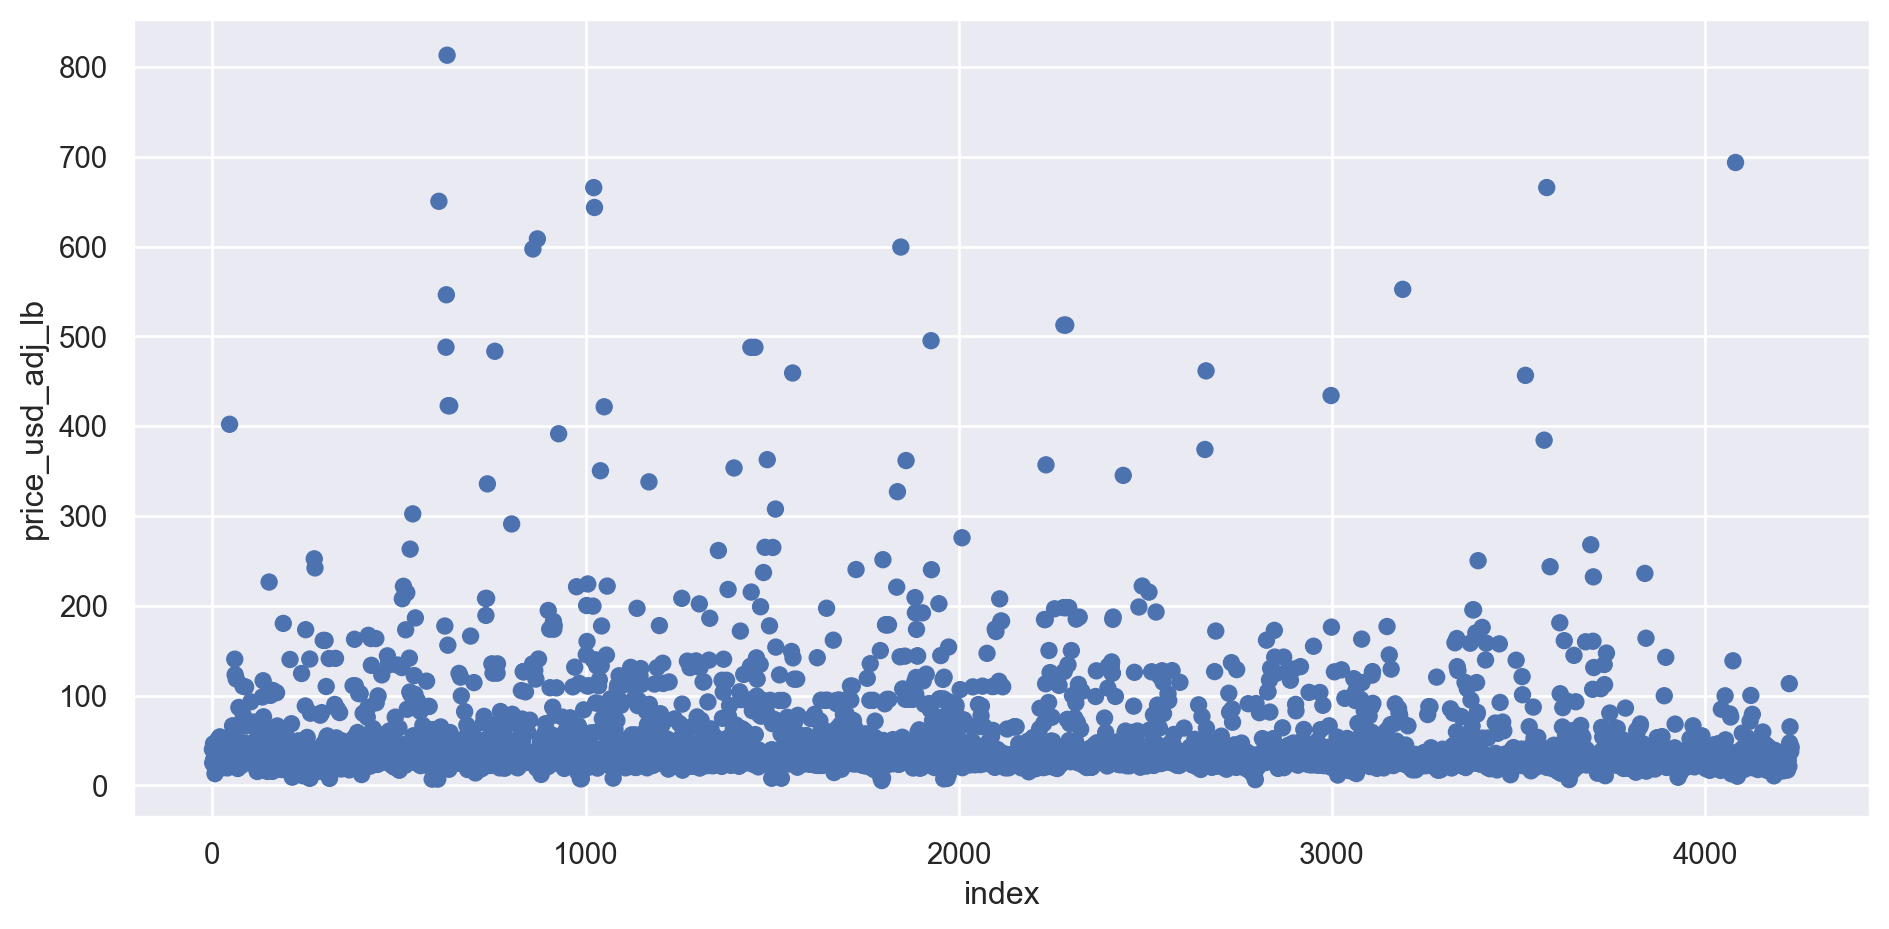

In [24]:
coffee = coffee[coffee["price_usd_adj_lb"] < 1000]
(
    coffee.reset_index()
    .pipe(so.Plot, x="index", y="price_usd_adj_lb")
    .add(so.Dot())
    .layout(size=(10, 5))
)

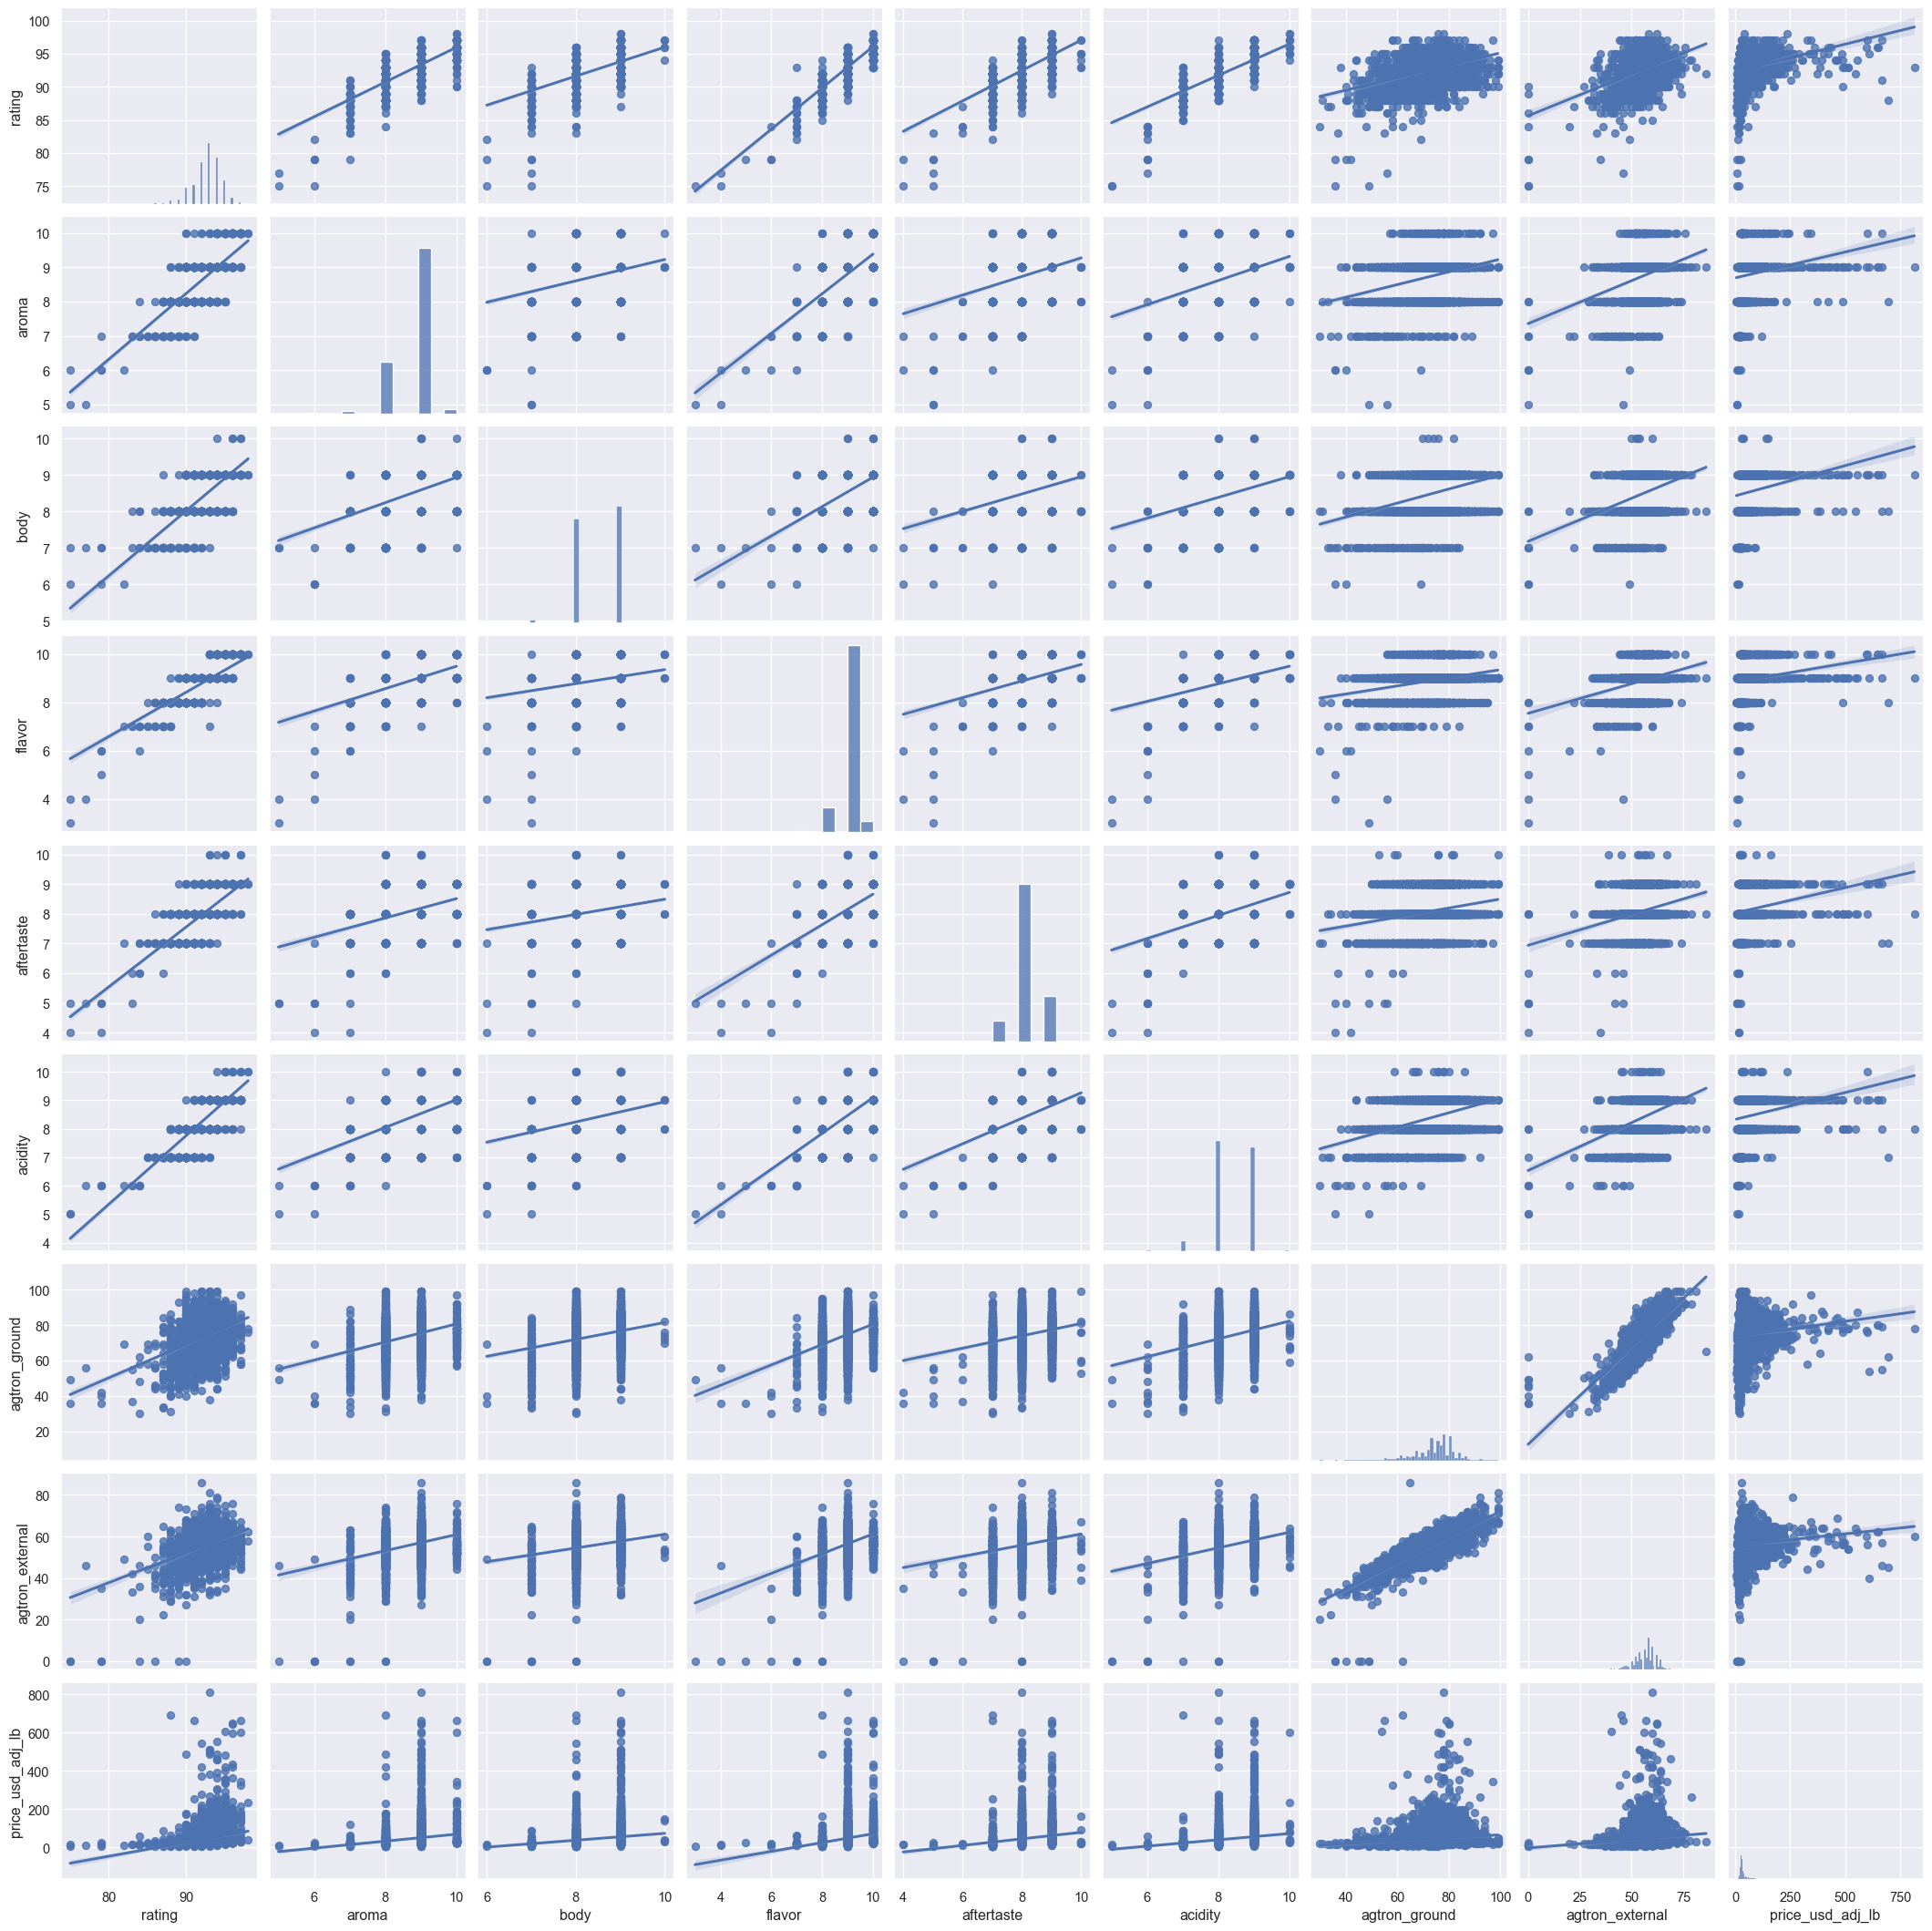

In [25]:
filtered = coffee[
    [
        "rating",
        "aroma",
        "body",
        "flavor",
        "aftertaste",
        "acidity",
        "agtron_ground",
        "agtron_external",
        "price_usd_adj_lb",
    ]
]

sns.pairplot(filtered, kind="reg")

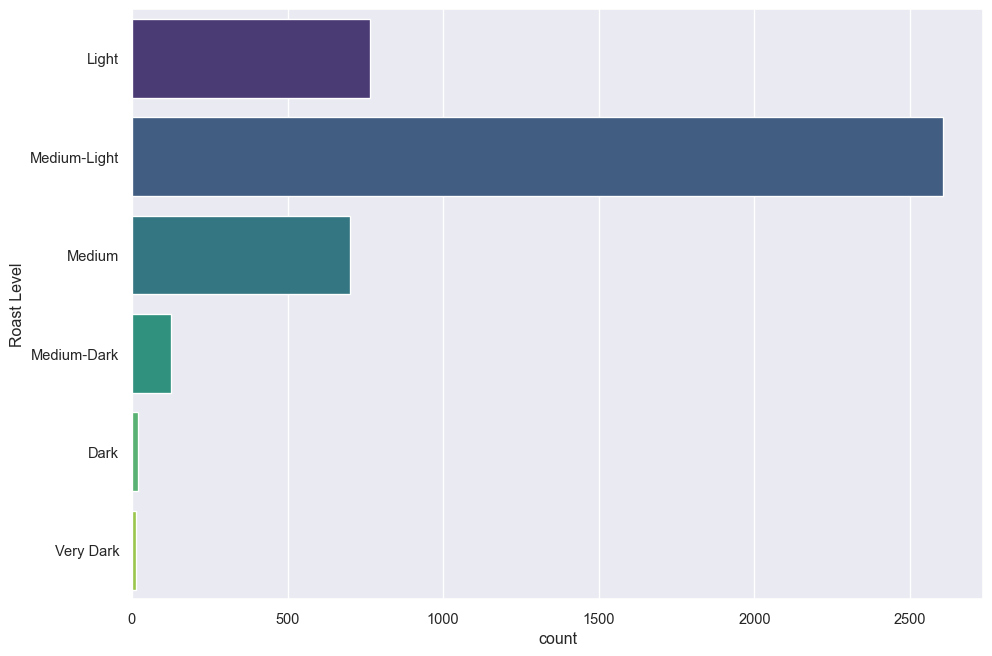

In [26]:
roast_count = (
    coffee["roast_level"]
    .value_counts()
    .reset_index()
    .sort_values("count", ascending=False)
)
roast_count
plt.figure(figsize=(10.5, 7))
sns.barplot(
    data=roast_count,
    y="roast_level",
    x="count",
    order=["Light", "Medium-Light", "Medium", "Medium-Dark", "Dark", "Very Dark"],
    palette="viridis",
)
plt.ylabel("Roast Level")
plt.tight_layout()
plt.show()

### Explore Distributions and Correlations

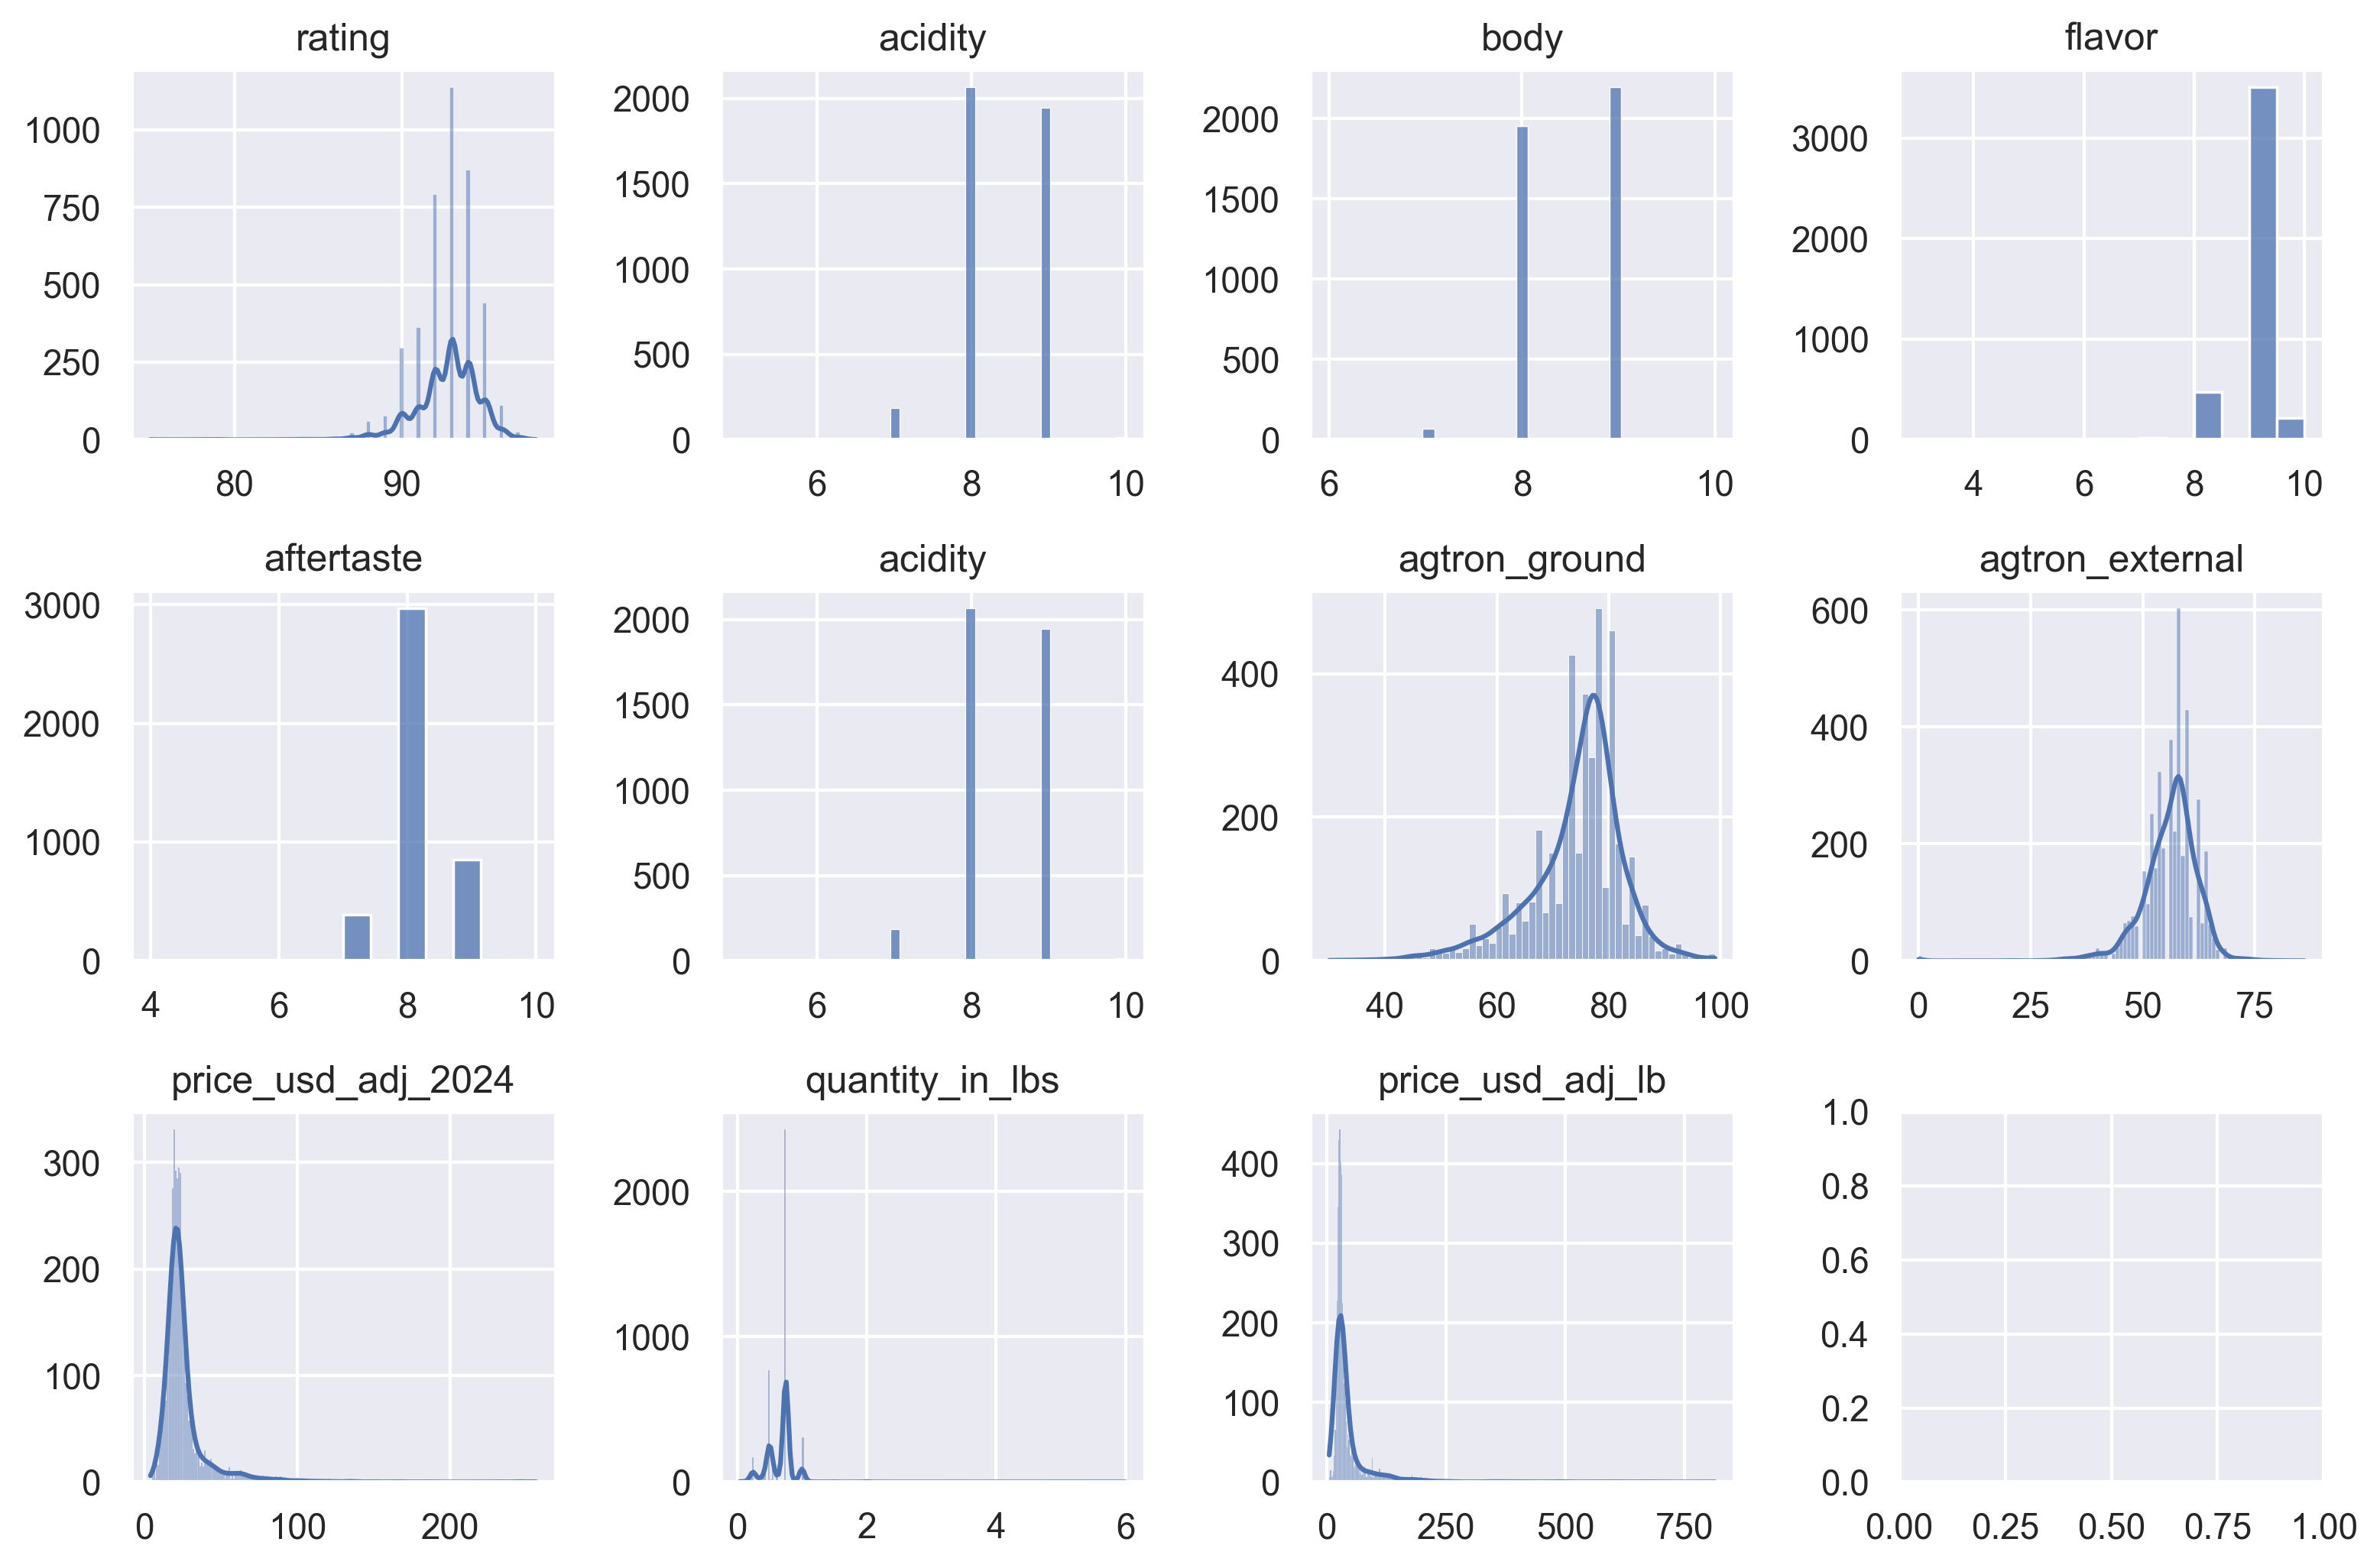

In [27]:
# Rating, acidity, body, flavor, aftertaste, acidity, agtrons, prive_per_lbs, quantity_lbs
sns.set_theme()

coffee_numeric = coffee.select_dtypes(include=[np.number])
fig, axs = plt.subplots(3, 4, figsize=(10.5, 7), dpi=300)

cols = [
    "rating",
    "acidity",
    "body",
    "flavor",
    "aftertaste",
    "acidity",
    "agtron_ground",
    "agtron_external",
    "price_usd_adj_2024",
    "quantity_in_lbs",
    "price_usd_adj_lb",
]
for i, col in enumerate(cols):
    # Plot kde for continuous variables, histogram for discrete variables
    kde = True
    if coffee_numeric[col].dtype == "int":
        kde = False
    sns.histplot(coffee_numeric[col], ax=axs[i // 4, i % 4], kde=kde)
    ax = axs[i // 4, i % 4]
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

# Price per Pound`

In [28]:
COL = "price_usd_lb_2024"
filtered = coffee_numeric[coffee_numeric[COL] < 200]

fig, axs = plt.subplots(1, 2, figsize=(10, 7.5))
sns.histplot(coffee_numeric, x=COL, ax=axs[0], kde=True)
sns.histplot(filtered, x=COL, ax=axs[1], kde=True)
plt.tight_layout()
plt.show()

KeyError: 'price_usd_lb_2024'

In [ ]:
mask = coffee["title"].str.contains("Geisha")
coffee_geisha = coffee[mask & (coffee["price_usd_adj_lb"] < 800)]
coffee_other = coffee[~mask & (coffee["price_usd_adj_lb"] < 800)]

fig, ax = plt.subplots(figsize=(10.5, 7))
sns.histplot(coffee_geisha, x="price_usd_adj_lb", bins=100, stat="density", kde=True)
sns.histplot(coffee_other, x="price_usd_adj_lb", bins=100, stat="density", kde=True)
plt.show()

In [ ]:
coffee_civet = coffee[(coffee["title"].str.contains("Civet")) | (coffee["notes   "])]
non_civet = coffee[
    ~coffee["title"].str.contains("Civet") & ~(coffee["title"].str.contains("Geisha"))
]

sns.boxplot(data=[coffee_civet["price_usd_adj_lb"], non_civet["price_usd_adj_lb"]])

In [ ]:
# Roasts with external agtron readings of 0 are roasts that were purchased and reviewed pre-ground
# Therefore no external agtron measurment was possibl
# change these to NAN
coffee[coffee["agtron_external"] == 0]